# Sistem Rekomendasi Diet dan Aktivitas Fisik

## 1. Import Library dan Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pickle
import os

# Set tampilan plot
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Fungsi untuk memuat dataset
def load_datasets(food_path='usda_cleaned_for_diet_app.csv', 
                 activity_path='physical_activities_cleaned.csv',
                 cardio_path='cardio_activities_cleaned.csv'):
    """
    Memuat ketiga dataset yang diperlukan untuk sistem rekomendasi.
    
    Parameters:
    food_path (str): Path ke file dataset makanan
    activity_path (str): Path ke file dataset aktivitas fisik
    cardio_path (str): Path ke file dataset aktivitas kardio
    
    Returns:
    tuple: (food_data, activity_data, cardio_data)
    """
    print("Memuat dataset makanan...")
    food_data = pd.read_csv(food_path)
    
    print("Memuat dataset aktivitas fisik...")
    activity_data = pd.read_csv(activity_path)
    
    print("Memuat dataset aktivitas kardio...")
    cardio_data = pd.read_csv(cardio_path)
    
    # Validasi dataset
    print("\nValidasi dataset:")
    print(f"Dataset makanan: {food_data.shape[0]} item dengan {food_data.shape[1]} atribut")
    print(f"Dataset aktivitas fisik: {activity_data.shape[0]} aktivitas dengan {activity_data.shape[1]} atribut")
    print(f"Dataset aktivitas kardio: {cardio_data.shape[0]} aktivitas kardio dengan {cardio_data.shape[1]} atribut")
    
    return food_data, activity_data, cardio_data

# Memuat dataset
food_data, activity_data, cardio_data = load_datasets()

Memuat dataset makanan...
Memuat dataset aktivitas fisik...
Memuat dataset aktivitas kardio...

Validasi dataset:
Dataset makanan: 9006 item dengan 13 atribut
Dataset aktivitas fisik: 857 aktivitas dengan 13 atribut
Dataset aktivitas kardio: 268 aktivitas kardio dengan 13 atribut


## 2. Model Perhitungan Kebutuhan Kalori

In [3]:
class CalorieCalculator:
    """
    Kelas untuk menghitung kebutuhan kalori harian berdasarkan data pengguna.
    Menggunakan rumus Harris-Benedict untuk BMR dan faktor aktivitas.
    """
    
    def __init__(self):
        # Faktor aktivitas berdasarkan tingkat aktivitas
        self.activity_factors = {
            'sedentary': 1.2,         # Aktivitas minimal (pekerjaan meja)
            'lightly_active': 1.375,   # Aktivitas ringan (olahraga 1-3 hari/minggu)
            'moderately_active': 1.55, # Aktivitas sedang (olahraga 3-5 hari/minggu)
            'very_active': 1.725,      # Aktivitas berat (olahraga 6-7 hari/minggu)
            'extra_active': 1.9        # Aktivitas sangat berat (atlet, pekerjaan fisik)
        }
        
        # Faktor penyesuaian tujuan
        self.goal_factors = {
            'weight_loss': -500,       # Defisit 500 kalori untuk penurunan ~0.5kg/minggu
            'maintain': 0,             # Pemeliharaan berat badan
            'weight_gain': 500         # Surplus 500 kalori untuk penambahan ~0.5kg/minggu
        }
    
    def calculate_bmr(self, weight, height, age, gender):
        """
        Menghitung Basal Metabolic Rate (BMR) menggunakan rumus Harris-Benedict.
        
        Parameters:
        weight (float): Berat badan dalam kg
        height (float): Tinggi badan dalam cm
        age (int): Usia dalam tahun
        gender (str): Jenis kelamin ('male' atau 'female')
        
        Returns:
        float: BMR dalam kalori/hari
        """
        if gender.lower() == 'male':
            bmr = 88.362 + (13.397 * weight) + (4.799 * height) - (5.677 * age)
        else:
            bmr = 447.593 + (9.247 * weight) + (3.098 * height) - (4.330 * age)
        
        return round(bmr)
    
    def calculate_tdee(self, bmr, activity_level):
        """
        Menghitung Total Daily Energy Expenditure (TDEE) berdasarkan BMR dan tingkat aktivitas.
        
        Parameters:
        bmr (float): BMR dalam kalori/hari
        activity_level (str): Tingkat aktivitas ('sedentary', 'lightly_active', dll)
        
        Returns:
        float: TDEE dalam kalori/hari
        """
        if activity_level not in self.activity_factors:
            raise ValueError(f"Tingkat aktivitas tidak valid: {activity_level}")
        
        tdee = bmr * self.activity_factors[activity_level]
        return round(tdee)
    
    def calculate_daily_calories(self, weight, height, age, gender, activity_level, goal):
        """
        Menghitung kebutuhan kalori harian berdasarkan data pengguna dan tujuan.
        
        Parameters:
        weight (float): Berat badan dalam kg
        height (float): Tinggi badan dalam cm
        age (int): Usia dalam tahun
        gender (str): Jenis kelamin ('male' atau 'female')
        activity_level (str): Tingkat aktivitas ('sedentary', 'lightly_active', dll)
        goal (str): Tujuan ('weight_loss', 'maintain', 'weight_gain')
        
        Returns:
        dict: Informasi kalori harian (bmr, tdee, target_calories)
        """
        if goal not in self.goal_factors:
            raise ValueError(f"Tujuan tidak valid: {goal}")
        
        # Hitung BMR
        bmr = self.calculate_bmr(weight, height, age, gender)
        
        # Hitung TDEE
        tdee = self.calculate_tdee(bmr, activity_level)
        
        # Hitung target kalori berdasarkan tujuan
        target_calories = tdee + self.goal_factors[goal]
        
        # Pastikan target kalori tidak terlalu rendah (minimum 1200 untuk wanita, 1500 untuk pria)
        min_calories = 1200 if gender.lower() == 'female' else 1500
        target_calories = max(target_calories, min_calories)
        
        return {
            'bmr': bmr,
            'tdee': tdee,
            'target_calories': round(target_calories)
        }
    
    def calculate_macronutrient_distribution(self, target_calories, goal):
        """
        Menghitung distribusi makronutrien berdasarkan target kalori dan tujuan.
        
        Parameters:
        target_calories (float): Target kalori harian
        goal (str): Tujuan ('weight_loss', 'maintain', 'weight_gain')
        
        Returns:
        dict: Distribusi makronutrien dalam gram (protein, fat, carbs)
        """
        # Distribusi makronutrien berdasarkan tujuan (protein/fat/carbs)
        macro_distribution = {
            'weight_loss': (0.30, 0.30, 0.40),      # Protein tinggi untuk preservasi otot
            'maintain': (0.25, 0.30, 0.45),         # Distribusi seimbang
            'weight_gain': (0.25, 0.25, 0.50)       # Karbohidrat tinggi untuk energi
        }
        
        if goal not in macro_distribution:
            raise ValueError(f"Tujuan tidak valid: {goal}")
        
        protein_pct, fat_pct, carbs_pct = macro_distribution[goal]
        
        # Kalori per gram: protein = 4, fat = 9, carbs = 4
        protein_calories = target_calories * protein_pct
        fat_calories = target_calories * fat_pct
        carbs_calories = target_calories * carbs_pct
        
        protein_grams = round(protein_calories / 4)
        fat_grams = round(fat_calories / 9)
        carbs_grams = round(carbs_calories / 4)
        
        return {
            'protein': protein_grams,
            'fat': fat_grams,
            'carbohydrate': carbs_grams,
            'protein_pct': protein_pct * 100,
            'fat_pct': fat_pct * 100,
            'carbs_pct': carbs_pct * 100
        }
    
    def validate_calorie_calculation(self, weight, height, age, gender, activity_level):
        """
        Memvalidasi perhitungan kalori dengan membandingkan dengan standar nutrisi.
        
        Parameters:
        weight (float): Berat badan dalam kg
        height (float): Tinggi badan dalam cm
        age (int): Usia dalam tahun
        gender (str): Jenis kelamin ('male' atau 'female')
        activity_level (str): Tingkat aktivitas
        
        Returns:
        dict: Hasil validasi (harris_benedict, mifflin_st_jeor, difference)
        """
        # Hitung dengan rumus Harris-Benedict (yang kita gunakan)
        hb_bmr = self.calculate_bmr(weight, height, age, gender)
        hb_tdee = self.calculate_tdee(hb_bmr, activity_level)
        
        # Hitung dengan rumus Mifflin-St Jeor (untuk validasi)
        if gender.lower() == 'male':
            msj_bmr = (10 * weight) + (6.25 * height) - (5 * age) + 5
        else:
            msj_bmr = (10 * weight) + (6.25 * height) - (5 * age) - 161
        
        msj_tdee = msj_bmr * self.activity_factors[activity_level]
        
        # Bandingkan hasil
        difference = abs(hb_tdee - msj_tdee)
        percent_diff = (difference / msj_tdee) * 100
        
        return {
            'harris_benedict': round(hb_tdee),
            'mifflin_st_jeor': round(msj_tdee),
            'difference': round(difference),
            'percent_difference': round(percent_diff, 2)
        }

## 3. Algoritma Rekomendasi Makanan

In [11]:
class FoodRecommender:
    """
    Kelas untuk merekomendasikan makanan berdasarkan kebutuhan nutrisi pengguna.
    """
    
    def __init__(self, food_data):
        """
        Inisialisasi dengan dataset makanan.
        
        Parameters:
        food_data (DataFrame): Dataset makanan dengan informasi nutrisi
        """
        self.food_data = food_data
        
        # Bersihkan nilai NaN dalam dataset
        self._clean_food_data()
        
        # Definisikan proporsi makanan untuk setiap waktu makan
        self.meal_proportions = {
            'breakfast': 0.25,  # 25% dari total kalori harian
            'lunch': 0.35,      # 35% dari total kalori harian
            'dinner': 0.30,     # 30% dari total kalori harian
            'snacks': 0.10      # 10% dari total kalori harian
        }
    
    def _clean_food_data(self):
        """Membersihkan nilai NaN dalam dataset makanan"""
        for col in ['calories', 'protein', 'fat', 'carbohydrate', 'fiber', 'sodium']:
            if col in self.food_data.columns:
                self.food_data[col] = self.food_data[col].fillna(0)
    
    def filter_by_allergies(self, allergies):
    """
    Memfilter makanan berdasarkan alergi pengguna.
    
    Parameters:
    allergies (list): Daftar alergi makanan
    
    Returns:
    DataFrame: Dataset makanan yang sudah difilter
    """
    if not allergies or len(allergies) == 0:
        return self.food_data
    
    filtered_data = self.food_data.copy()
    
    # Pastikan kolom allergens dan name adalah string
    if 'allergens' in filtered_data.columns:
        filtered_data['allergens'] = filtered_data['allergens'].astype(str)
    else:
        filtered_data['allergens'] = 'None'
        
    filtered_data['name'] = filtered_data['name'].astype(str)
    
    # Filter makanan yang mengandung alergen
    for allergen in allergies:
        allergen_lower = allergen.lower()
        # Filter berdasarkan kolom allergens dan nama makanan
        filtered_data = filtered_data[
            ~(filtered_data['allergens'].str.lower().str.contains(allergen_lower, na=False)) & 
            ~(filtered_data['name'].str.lower().str.contains(allergen_lower, na=False))
        ]
    
    return filtered_data
    
    def get_meal_nutrient_targets(self, daily_targets, meal_type):
        """
        Menghitung target nutrisi untuk satu waktu makan.
        
        Parameters:
        daily_targets (dict): Target nutrisi harian
        meal_type (str): Jenis waktu makan ('breakfast', 'lunch', 'dinner', 'snacks')
        
        Returns:
        dict: Target nutrisi untuk waktu makan tersebut
        """
        if meal_type not in self.meal_proportions:
            raise ValueError(f"Jenis waktu makan tidak valid: {meal_type}")
        
        proportion = self.meal_proportions[meal_type]
        
        meal_targets = {
            'calories': daily_targets['target_calories'] * proportion,
            'protein': daily_targets['macros']['protein'] * proportion,
            'fat': daily_targets['macros']['fat'] * proportion,
            'carbohydrate': daily_targets['macros']['carbohydrate'] * proportion
        }
        
        return {k: round(v) for k, v in meal_targets.items()}
    
    def select_foods_for_meal(self, filtered_foods, meal_targets, meal_size=3, prefer_categories=None):
        """
        Memilih makanan untuk satu waktu makan berdasarkan target nutrisi.
        
        Parameters:
        filtered_foods (DataFrame): Dataset makanan yang sudah difilter
        meal_targets (dict): Target nutrisi untuk waktu makan
        meal_size (int): Jumlah makanan yang direkomendasikan
        prefer_categories (list): Kategori makanan yang diutamakan
        
        Returns:
        DataFrame: Makanan yang direkomendasikan
        """
        # Salin dataset untuk menghindari warning SettingWithCopyWarning
        foods = filtered_foods.copy()
        
        # Filter makanan dengan kalori > 0 untuk menghindari pembagian dengan nol
        foods = foods[foods['calories'] > 0]
        
        if len(foods) == 0:
            return pd.DataFrame()
        
        # Hitung skor nutrisi untuk setiap makanan
        # Skor lebih tinggi = lebih dekat dengan target proporsi makronutrien
        
        # Target proporsi makronutrien
        target_protein_ratio = meal_targets['protein'] * 4 / meal_targets['calories']
        target_fat_ratio = meal_targets['fat'] * 9 / meal_targets['calories']
        target_carb_ratio = meal_targets['carbohydrate'] * 4 / meal_targets['calories']
        
        # Hitung proporsi makronutrien untuk setiap makanan
        foods['protein_ratio'] = (foods['protein'] * 4) / foods['calories']
        foods['fat_ratio'] = (foods['fat'] * 9) / foods['calories']
        foods['carb_ratio'] = (foods['carbohydrate'] * 4) / foods['calories']
        
        # Hitung skor berdasarkan seberapa dekat dengan target proporsi
        foods['protein_score'] = 1 - abs(foods['protein_ratio'] - target_protein_ratio)
        foods['fat_score'] = 1 - abs(foods['fat_ratio'] - target_fat_ratio)
        foods['carb_score'] = 1 - abs(foods['carb_ratio'] - target_carb_ratio)
        
        # Skor nutrisi total
        foods['nutrient_score'] = (foods['protein_score'] + foods['fat_score'] + foods['carb_score']) / 3
        
        # Tambahkan bonus untuk kategori yang diutamakan
        if prefer_categories and len(prefer_categories) > 0:
            foods['category_bonus'] = foods['food_category'].apply(
                lambda x: 0.2 if x in prefer_categories else 0
            )
            foods['final_score'] = foods['nutrient_score'] + foods['category_bonus']
        else:
            foods['final_score'] = foods['nutrient_score']
        
        # Pilih makanan dengan skor tertinggi
        selected_foods = foods.sort_values('final_score', ascending=False).head(meal_size * 2)
        
        # Algoritma greedy untuk memilih kombinasi makanan yang mendekati target
        selected_indices = []
        current_calories = 0
        current_protein = 0
        current_fat = 0
        current_carbs = 0
        
        # Urutkan makanan berdasarkan skor
        candidate_foods = selected_foods.sort_values('final_score', ascending=False)
        
        # Pilih makanan secara greedy
        for idx, food in candidate_foods.iterrows():
            # Jika sudah mencapai jumlah makanan yang diinginkan
            if len(selected_indices) >= meal_size:
                break
                
            # Jika menambahkan makanan ini tidak melebihi target
            new_calories = current_calories + food['calories']
            if new_calories <= meal_targets['calories'] * 1.1:  # Toleransi 10%
                selected_indices.append(idx)
                current_calories = new_calories
                current_protein += food['protein']
                current_fat += food['fat']
                current_carbs += food['carbohydrate']
        
        # Jika tidak cukup makanan yang dipilih, tambahkan makanan teratas
        while len(selected_indices) < meal_size and len(candidate_foods) > len(selected_indices):
            for idx, food in candidate_foods.iterrows():
                if idx not in selected_indices:
                    selected_indices.append(idx)
                    break
                    
        # Ambil makanan yang dipilih
        recommended_foods = foods.loc[selected_indices].copy()
        
        # Tambahkan kolom porsi yang direkomendasikan
        if len(recommended_foods) > 0:
            # Jika tidak ada makanan yang dipilih, hindari pembagian dengan nol
            total_calories = recommended_foods['calories'].sum()
            if total_calories > 0:
                calorie_ratio = meal_targets['calories'] / total_calories
                recommended_foods['recommended_portion'] = recommended_foods['portion_size'] * calorie_ratio
                recommended_foods['adjusted_calories'] = recommended_foods['calories'] * calorie_ratio
            else:
                recommended_foods['recommended_portion'] = recommended_foods['portion_size']
                recommended_foods['adjusted_calories'] = recommended_foods['calories']
        
        return recommended_foods[['name', 'calories', 'protein', 'fat', 'carbohydrate', 
                                 'fiber', 'sodium', 'portion_size', 'serving_unit', 
                                 'food_category', 'recommended_portion', 'adjusted_calories']]
    
    def generate_daily_meal_plan(self, user_profile, daily_targets):
        """
        Menghasilkan rencana makan harian berdasarkan profil pengguna dan target nutrisi.
        
        Parameters:
        user_profile (dict): Profil pengguna (termasuk alergi)
        daily_targets (dict): Target nutrisi harian
        
        Returns:
        dict: Rencana makan harian (breakfast, lunch, dinner, snacks)
        """
        # Filter makanan berdasarkan alergi
        allergies = user_profile.get('allergies', [])
        filtered_foods = self.filter_by_allergies(allergies)
        
        # Kategori makanan yang diutamakan untuk setiap waktu makan
        meal_categories = {
            'breakfast': ['Breakfast Foods', 'Cereals', 'Dairy', 'Fruits'],
            'lunch': ['Vegetables', 'Soups', 'Sandwiches', 'Salads', 'Proteins'],
            'dinner': ['Proteins', 'Vegetables', 'Grains', 'Pasta'],
            'snacks': ['Fruits', 'Nuts', 'Yogurt', 'Snacks']
        }
        
        # Ukuran makanan untuk setiap waktu makan
        meal_sizes = {
            'breakfast': 3,
            'lunch': 4,
            'dinner': 4,
            'snacks': 2
        }
        
        meal_plan = {}
        
        # Hasilkan rekomendasi untuk setiap waktu makan
        for meal_type in ['breakfast', 'lunch', 'dinner', 'snacks']:
            # Hitung target nutrisi untuk waktu makan ini
            meal_targets = self.get_meal_nutrient_targets(daily_targets, meal_type)
            
            # Pilih makanan untuk waktu makan ini
            recommended_foods = self.select_foods_for_meal(
                filtered_foods, 
                meal_targets, 
                meal_size=meal_sizes[meal_type],
                prefer_categories=meal_categories[meal_type]
            )
            
            meal_plan[meal_type] = {
                'targets': meal_targets,
                'foods': recommended_foods,
                'totals': {
                    'calories': round(recommended_foods['adjusted_calories'].sum()),
                    'protein': round(recommended_foods['protein'].sum()),
                    'fat': round(recommended_foods['fat'].sum()),
                    'carbohydrate': round(recommended_foods['carbohydrate'].sum()),
                    'fiber': round(recommended_foods['fiber'].sum()),
                    'sodium': round(recommended_foods['sodium'].sum())
                }
            }
        
        # Hitung total nutrisi untuk seluruh hari
        daily_totals = {
            'calories': sum(meal['totals']['calories'] for meal in meal_plan.values()),
            'protein': sum(meal['totals']['protein'] for meal in meal_plan.values()),
            'fat': sum(meal['totals']['fat'] for meal in meal_plan.values()),
            'carbohydrate': sum(meal['totals']['carbohydrate'] for meal in meal_plan.values()),
            'fiber': sum(meal['totals']['fiber'] for meal in meal_plan.values()),
            'sodium': sum(meal['totals']['sodium'] for meal in meal_plan.values())
        }
        
        meal_plan['daily_totals'] = daily_totals
        
        return meal_plan

IndentationError: expected an indented block (4079823668.py, line 41)

## 4. Model Prediksi Perubahan Berat Badan

In [5]:
class WeightChangePredictor:
    """
    Kelas untuk memprediksi perubahan berat badan berdasarkan asupan dan aktivitas.
    """
    
    def __init__(self):
        # Konstanta untuk model thermodynamics
        self.calories_per_kg_fat = 7700  # ~7700 kalori per kg lemak
        
        # Faktor metabolisme untuk penyesuaian individual
        self.metabolism_factors = {
            'slow': 0.9,        # Metabolisme lambat
            'normal': 1.0,      # Metabolisme normal
            'fast': 1.1         # Metabolisme cepat
        }
    
    def predict_weight_change(self, initial_weight, daily_calorie_deficit, days, metabolism_type='normal'):
        """
        Memprediksi perubahan berat badan berdasarkan defisit kalori harian.
        
        Parameters:
        initial_weight (float): Berat badan awal dalam kg
        daily_calorie_deficit (float): Defisit kalori harian (negatif = defisit, positif = surplus)
        days (int): Jumlah hari untuk prediksi
        metabolism_type (str): Tipe metabolisme ('slow', 'normal', 'fast')
        
        Returns:
        dict: Prediksi berat badan dan informasi terkait
        """
        if metabolism_type not in self.metabolism_factors:
            raise ValueError(f"Tipe metabolisme tidak valid: {metabolism_type}")
        
        # Sesuaikan defisit kalori berdasarkan faktor metabolisme
        adjusted_deficit = daily_calorie_deficit * self.metabolism_factors[metabolism_type]
        
        # Hitung perubahan berat badan dalam kg
        total_calorie_deficit = adjusted_deficit * days
        weight_change_kg = total_calorie_deficit / self.calories_per_kg_fat
        
        # Prediksi berat badan akhir
        final_weight = initial_weight - weight_change_kg
        
        # Pastikan berat badan akhir tidak negatif atau tidak realistis
        final_weight = max(final_weight, initial_weight * 0.5)  # Tidak kurang dari 50% berat awal
        
        # Hitung informasi tambahan
        daily_weight_change = weight_change_kg / days
        weeks = days / 7
        weekly_weight_change = weight_change_kg / weeks if weeks > 0 else 0
        
        return {
            'initial_weight': initial_weight,
            'final_weight': round(final_weight, 2),
            'weight_change_kg': round(weight_change_kg, 2),
            'daily_weight_change': round(daily_weight_change, 3),
            'weekly_weight_change': round(weekly_weight_change, 2),
            'days': days,
            'daily_calorie_deficit': round(adjusted_deficit),
            'metabolism_factor': self.metabolism_factors[metabolism_type]
        }
    
    def generate_weight_trajectory(self, initial_weight, daily_calorie_deficit, days, metabolism_type='normal'):
        """
        Menghasilkan trajektori berat badan selama periode tertentu.
        
        Parameters:
        initial_weight (float): Berat badan awal dalam kg
        daily_calorie_deficit (float): Defisit kalori harian
        days (int): Jumlah hari untuk prediksi
        metabolism_type (str): Tipe metabolisme
        
        Returns:
        DataFrame: Trajektori berat badan harian
        """
        # Buat array untuk hari dan berat badan
        day_array = np.arange(days + 1)
        weight_array = np.zeros(days + 1)
        weight_array[0] = initial_weight
        
        # Sesuaikan defisit kalori berdasarkan faktor metabolisme
        adjusted_deficit = daily_calorie_deficit * self.metabolism_factors[metabolism_type]
        
        # Hitung perubahan berat badan harian
        daily_weight_change = adjusted_deficit / self.calories_per_kg_fat
        
        # Hitung berat badan untuk setiap hari
        for i in range(1, days + 1):
            # Tambahkan sedikit noise untuk model yang lebih realistis (±10%)
            noise_factor = 1 + np.random.uniform(-0.1, 0.1)
            daily_change = daily_weight_change * noise_factor
            
            # Update berat badan
            weight_array[i] = weight_array[i-1] - daily_change
            
            # Pastikan berat badan tidak turun terlalu drastis
            min_weight = initial_weight * 0.5
            weight_array[i] = max(weight_array[i], min_weight)
        
        # Buat DataFrame
        trajectory_df = pd.DataFrame({
            'day': day_array,
            'weight': weight_array,
            'weight_change': np.concatenate(([0], np.diff(weight_array)))
        })
        
        # Tambahkan tanggal
        start_date = datetime.now()
        trajectory_df['date'] = trajectory_df['day'].apply(lambda x: (start_date + timedelta(days=x)).strftime('%Y-%m-%d'))
        
        return trajectory_df
    
    def validate_model(self, test_data):
        """
        Memvalidasi model dengan data historis.
        
        Parameters:
        test_data (DataFrame): Data historis dengan kolom 'initial_weight', 'daily_calorie_deficit', 'days', 'final_weight'
        
        Returns:
        dict: Metrik validasi
        """
        if len(test_data) == 0:
            return {'error': 'No test data provided'}
        
        # Prediksi berat badan akhir untuk setiap baris data
        predicted_weights = []
        for _, row in test_data.iterrows():
            prediction = self.predict_weight_change(
                row['initial_weight'],
                row['daily_calorie_deficit'],
                row['days'],
                row.get('metabolism_type', 'normal')
            )
            predicted_weights.append(prediction['final_weight'])
        
        # Hitung metrik error
        actual_weights = test_data['final_weight'].values
        mae = mean_absolute_error(actual_weights, predicted_weights)
        
        # Hitung persentase error
        percent_errors = [abs(a - p) / a * 100 for a, p in zip(actual_weights, predicted_weights)]
        mean_percent_error = sum(percent_errors) / len(percent_errors)
        
        return {
            'mean_absolute_error': round(mae, 2),
            'mean_percent_error': round(mean_percent_error, 2),
            'sample_size': len(test_data)
        }
    
    def plot_weight_trajectory(self, trajectory_df, target_weight=None):
        """
        Membuat visualisasi trajektori berat badan.
        
        Parameters:
        trajectory_df (DataFrame): Trajektori berat badan dari generate_weight_trajectory
        target_weight (float, optional): Berat badan target
        
        Returns:
        matplotlib.figure.Figure: Objek figure matplotlib
        """
        plt.figure(figsize=(12, 6))
        
        # Plot trajektori berat badan
        plt.plot(trajectory_df['day'], trajectory_df['weight'], 'b-', linewidth=2)
        
        # Tambahkan garis target jika disediakan
        if target_weight is not None:
            plt.axhline(y=target_weight, color='r', linestyle='--', label=f'Target: {target_weight} kg')
            
            # Cari hari saat target tercapai (jika ada)
            if trajectory_df['weight'].min() <= target_weight <= trajectory_df['weight'].max():
                # Cari hari terdekat dengan target
                closest_day = trajectory_df.iloc[(trajectory_df['weight'] - target_weight).abs().argsort()[0]]
                plt.scatter([closest_day['day']], [closest_day['weight']], color='r', s=100, zorder=5)
                plt.annotate(f"Target tercapai: Hari {int(closest_day['day'])}", 
                            xy=(closest_day['day'], closest_day['weight']),
                            xytext=(closest_day['day'] + 5, closest_day['weight'] + 1),
                            arrowprops=dict(arrowstyle='->'))
        
        # Tambahkan anotasi untuk berat awal dan akhir
        initial_weight = trajectory_df['weight'].iloc[0]
        final_weight = trajectory_df['weight'].iloc[-1]
        weight_change = final_weight - initial_weight
        
        plt.scatter([0], [initial_weight], color='g', s=100, zorder=5)
        plt.annotate(f"Awal: {initial_weight:.1f} kg", 
                    xy=(0, initial_weight),
                    xytext=(5, initial_weight + 1))
        
        plt.scatter([trajectory_df['day'].max()], [final_weight], color='g', s=100, zorder=5)
        plt.annotate(f"Akhir: {final_weight:.1f} kg\nPerubahan: {weight_change:.1f} kg", 
                    xy=(trajectory_df['day'].max(), final_weight),
                    xytext=(trajectory_df['day'].max() - 30, final_weight + 1))
        
        # Tambahkan label dan judul
        plt.xlabel('Hari')
        plt.ylabel('Berat Badan (kg)')
        plt.title('Prediksi Perubahan Berat Badan')
        plt.grid(True)
        plt.legend()
        
        return plt.gcf()

## 5. Algoritma Rekomendasi Aktivitas Fisik

In [6]:
class ActivityRecommender:
    """
    Kelas untuk merekomendasikan aktivitas fisik berdasarkan data pengguna dan tujuan.
    """
    
    def __init__(self, activity_data, cardio_data):
        """
        Inisialisasi dengan dataset aktivitas fisik.
        
        Parameters:
        activity_data (DataFrame): Dataset aktivitas fisik
        cardio_data (DataFrame): Dataset aktivitas kardio
        """
        self.activity_data = activity_data
        self.cardio_data = cardio_data
        
        # Definisikan level kebugaran dan faktor penyesuaian
        self.fitness_levels = {
            'beginner': {'intensity': 'Ringan', 'duration_factor': 0.8},
            'intermediate': {'intensity': 'Sedang', 'duration_factor': 1.0},
            'advanced': {'intensity': 'Berat', 'duration_factor': 1.2}
        }
    
    def calculate_calories_burned(self, activity_id, weight_kg, duration_minutes):
        """
        Menghitung kalori yang terbakar untuk aktivitas tertentu.
        
        Parameters:
        activity_id (int): ID aktivitas
        weight_kg (float): Berat badan dalam kg
        duration_minutes (float): Durasi aktivitas dalam menit
        
        Returns:
        float: Kalori yang terbakar
        """
        # Cari aktivitas dalam dataset
        activity = self.activity_data[self.activity_data['activity_id'] == activity_id]
        
        if len(activity) == 0:
            return 0
        
        # Ambil nilai MET
        met_value = activity['met_value'].values[0]
        
        # Hitung kalori terbakar
        # Rumus: Kalori = MET × berat (kg) × durasi (jam)
        calories_burned = met_value * weight_kg * (duration_minutes / 60)
        
        return round(calories_burned)
    
    def recommend_running_activity(self, user_profile, target_calories=None):
        """
        Merekomendasikan aktivitas lari berdasarkan profil pengguna.
        
        Parameters:
        user_profile (dict): Profil pengguna
        target_calories (float, optional): Target kalori yang ingin dibakar
        
        Returns:
        dict: Rekomendasi aktivitas lari
        """
        weight_kg = user_profile['weight']
        fitness_level = user_profile.get('fitness_level', 'beginner')
        
        if fitness_level not in self.fitness_levels:
            fitness_level = 'beginner'
        
        # Filter aktivitas lari berdasarkan level kebugaran
        recommended_intensity = self.fitness_levels[fitness_level]['intensity']
        running_activities = self.cardio_data[
            (self.cardio_data['activity_name'].str.contains('run|jog', case=False)) &
            (self.cardio_data['intensity_level'] == recommended_intensity)
        ]
        
        # Jika tidak ada aktivitas yang cocok, gunakan semua aktivitas lari
        if len(running_activities) == 0:
            running_activities = self.cardio_data[
                self.cardio_data['activity_name'].str.contains('run|jog', case=False)
            ]
        
        # Jika masih tidak ada, gunakan aktivitas kardio apa saja
        if len(running_activities) == 0:
            running_activities = self.cardio_data
        
        # Pilih aktivitas lari yang paling sesuai
        selected_activity = running_activities.iloc[0]
        
        # Tentukan durasi berdasarkan target kalori atau rekomendasi default
        duration_minutes = 30  # Durasi default
        
        if target_calories is not None:
            # Hitung durasi yang diperlukan untuk mencapai target kalori
            met_value = selected_activity['met_value']
            duration_hours = target_calories / (met_value * weight_kg)
            duration_minutes = round(duration_hours * 60)
            
            # Pastikan durasi masuk akal (10-60 menit)
            duration_minutes = max(10, min(60, duration_minutes))
        else:
            # Sesuaikan durasi berdasarkan level kebugaran
            duration_factor = self.fitness_levels[fitness_level]['duration_factor']
            duration_minutes = round(duration_minutes * duration_factor)
        
        # Hitung kalori yang terbakar
        calories_burned = self.calculate_calories_burned(
            selected_activity['activity_id'],
            weight_kg,
            duration_minutes
        )
        
        # Hitung jarak berdasarkan kecepatan yang tersirat dalam nama aktivitas
        distance_km = self._estimate_running_distance(selected_activity['activity_name'], duration_minutes)
        
        return {
            'activity_id': selected_activity['activity_id'],
            'activity_name': selected_activity['activity_name'],
            'intensity_level': selected_activity['intensity_level'],
            'duration_minutes': duration_minutes,
            'distance_km': distance_km,
            'calories_burned': calories_burned,
            'equipment_needed': selected_activity['equipment_needed'],
            'location': selected_activity['location']
        }
    
    def _estimate_running_distance(self, activity_name, duration_minutes):
        """
        Memperkirakan jarak lari berdasarkan nama aktivitas dan durasi.
        
        Parameters:
        activity_name (str): Nama aktivitas
        duration_minutes (float): Durasi aktivitas dalam menit
        
        Returns:
        float: Perkiraan jarak dalam km
        """
        # Coba ekstrak kecepatan dari nama aktivitas (mis. "Running, 6 mph")
        import re
        
        # Cari pola kecepatan dalam mph
        mph_match = re.search(r'(\d+(\.\d+)?)\s*mph', activity_name)
        if mph_match:
            mph = float(mph_match.group(1))
            # Konversi mph ke km/h
            kmh = mph * 1.60934
            # Hitung jarak: kecepatan × waktu
            distance_km = kmh * (duration_minutes / 60)
            return round(distance_km, 2)
        
        # Jika tidak ada kecepatan, gunakan perkiraan berdasarkan intensitas
        if 'slow' in activity_name.lower() or 'light' in activity_name.lower():
            kmh = 6  # ~6 km/h untuk lari lambat
        elif 'moderate' in activity_name.lower():
            kmh = 8  # ~8 km/h untuk lari sedang
        elif 'fast' in activity_name.lower() or 'vigorous' in activity_name.lower():
            kmh = 10  # ~10 km/h untuk lari cepat
        else:
            kmh = 7  # Nilai default
        
        # Hitung jarak
        distance_km = kmh * (duration_minutes / 60)
        return round(distance_km, 2)
    
    def recommend_activities_for_goal(self, user_profile, goal, target_calories=None, preferred_location=None):
        """
        Merekomendasikan aktivitas fisik berdasarkan tujuan pengguna.
        
        Parameters:
        user_profile (dict): Profil pengguna
        goal (str): Tujuan ('weight_loss', 'cardiovascular_health', 'muscle_tone', 'general_fitness')
        target_calories (float, optional): Target kalori yang ingin dibakar
        preferred_location (str, optional): Lokasi yang diutamakan ('Indoor', 'Outdoor', 'Both')
        
        Returns:
        DataFrame: Aktivitas yang direkomendasikan
        """
        weight_kg = user_profile['weight']
        fitness_level = user_profile.get('fitness_level', 'beginner')
        
        # Filter aktivitas berdasarkan tujuan
        filtered_activities = self.activity_data[
            self.activity_data['diet_targets'].str.contains(goal, case=False)
        ]
        
        # Filter berdasarkan level kebugaran
        recommended_intensity = self.fitness_levels[fitness_level]['intensity']
        filtered_activities = filtered_activities[
            filtered_activities['intensity_level'] == recommended_intensity
        ]
        
        # Filter berdasarkan lokasi jika ditentukan
        if preferred_location and preferred_location != 'Both':
            filtered_activities = filtered_activities[
                filtered_activities['location'] == preferred_location
            ]
        
        # Jika tidak ada aktivitas yang cocok, gunakan semua aktivitas
        if len(filtered_activities) == 0:
            filtered_activities = self.activity_data
        
        # Pilih aktivitas teratas
        top_activities = filtered_activities.head(5).copy()
        
        # Hitung kalori yang terbakar dan durasi untuk setiap aktivitas
        for idx, activity in top_activities.iterrows():
            # Tentukan durasi berdasarkan target kalori atau rekomendasi default
            duration_minutes = 30  # Durasi default
            
            if target_calories is not None:
                # Hitung durasi yang diperlukan untuk mencapai target kalori
                met_value = activity['met_value']
                duration_hours = target_calories / (met_value * weight_kg)
                duration_minutes = round(duration_hours * 60)
                
                # Pastikan durasi masuk akal (10-60 menit)
                duration_minutes = max(10, min(60, duration_minutes))
            else:
                # Sesuaikan durasi berdasarkan level kebugaran
                duration_factor = self.fitness_levels[fitness_level]['duration_factor']
                duration_minutes = round(duration_minutes * duration_factor)
            
            # Hitung kalori yang terbakar
            calories_burned = self.calculate_calories_burned(
                activity['activity_id'],
                weight_kg,
                duration_minutes
            )
            
            # Tambahkan ke DataFrame
            top_activities.at[idx, 'recommended_duration_minutes'] = duration_minutes
            top_activities.at[idx, 'calories_burned'] = calories_burned
        
        # Pilih kolom yang relevan
        result = top_activities[[
            'activity_id', 'activity_name', 'intensity_level', 
            'recommended_duration_minutes', 'calories_burned',
            'equipment_needed', 'location'
        ]]
        
        return result
    
    def generate_weekly_activity_plan(self, user_profile, daily_calorie_targets):
        """
        Menghasilkan rencana aktivitas fisik mingguan.
        
        Parameters:
        user_profile (dict): Profil pengguna
        daily_calorie_targets (dict): Target kalori harian
        
        Returns:
        dict: Rencana aktivitas mingguan
        """
        weight_kg = user_profile['weight']
        goal = user_profile.get('goal', 'weight_loss')
        fitness_level = user_profile.get('fitness_level', 'beginner')
        
        # Konversi goal ke target aktivitas
        if goal == 'weight_loss':
            activity_goal = 'weight_loss'
        elif goal == 'muscle_gain':
            activity_goal = 'muscle_tone'
        else:
            activity_goal = 'general_fitness'
        
        # Target kalori untuk dibakar melalui aktivitas
        target_burn_calories = daily_calorie_targets.get('activity_calories', 300)
        
        # Buat rencana mingguan
        weekly_plan = {}
        
        # Tentukan jumlah hari aktivitas berdasarkan level kebugaran
        if fitness_level == 'beginner':
            activity_days = 3  # 3 hari per minggu
        elif fitness_level == 'intermediate':
            activity_days = 5  # 5 hari per minggu
        else:
            activity_days = 6  # 6 hari per minggu
        
        # Tentukan jenis aktivitas untuk setiap hari
        day_types = {
            0: 'cardio',       # Hari 1: Kardio (lari)
            1: 'strength',     # Hari 2: Kekuatan
            2: 'cardio',       # Hari 3: Kardio
            3: 'flexibility',  # Hari 4: Fleksibilitas
            4: 'cardio',       # Hari 5: Kardio
            5: 'strength',     # Hari 6: Kekuatan
            6: 'rest'          # Hari 7: Istirahat
        }
        
        # Buat rencana untuk 7 hari
        for day in range(7):
            # Jika melebihi jumlah hari aktivitas, jadikan hari istirahat
            if day >= activity_days:
                day_type = 'rest'
            else:
                day_type = day_types[day]
            
            if day_type == 'rest':
                # Hari istirahat
                weekly_plan[day] = {
                    'day_type': 'rest',
                    'activities': [],
                    'total_calories_burned': 0,
                    'total_duration_minutes': 0
                }
            elif day_type == 'cardio':
                # Hari kardio (lari)
                running_recommendation = self.recommend_running_activity(
                    user_profile,
                    target_calories=target_burn_calories
                )
                
                weekly_plan[day] = {
                    'day_type': 'cardio',
                    'activities': [running_recommendation],
                    'total_calories_burned': running_recommendation['calories_burned'],
                    'total_duration_minutes': running_recommendation['duration_minutes']
                }
            else:
                # Hari kekuatan atau fleksibilitas
                activities = self.recommend_activities_for_goal(
                    user_profile,
                    'muscle_tone' if day_type == 'strength' else 'general_fitness',
                    target_calories=target_burn_calories / 2  # Dibagi 2 karena biasanya ada 2 aktivitas
                )
                
                # Konversi DataFrame ke list of dict
                activity_list = activities.head(2).to_dict('records')
                
                weekly_plan[day] = {
                    'day_type': day_type,
                    'activities': activity_list,
                    'total_calories_burned': sum(a['calories_burned'] for a in activity_list),
                    'total_duration_minutes': sum(a['recommended_duration_minutes'] for a in activity_list)
                }
        
        # Hitung total kalori terbakar per minggu
        total_weekly_calories = sum(day['total_calories_burned'] for day in weekly_plan.values())
        
        return {
            'daily_plan': weekly_plan,
            'total_weekly_calories_burned': total_weekly_calories,
            'activity_days': activity_days,
            'rest_days': 7 - activity_days
        }

## 6. Sistem Pembelajaran Adaptif

In [7]:
class AdaptiveLearningSystem:
    """
    Kelas untuk sistem pembelajaran adaptif yang menyesuaikan rekomendasi berdasarkan feedback pengguna.
    """
    
    def __init__(self):
        # Inisialisasi penyimpanan data pengguna
        self.user_preferences = {}
        self.user_feedback = {}
        self.success_patterns = {}
    
    def record_food_preference(self, user_id, food_id, preference_score):
        """
        Mencatat preferensi makanan pengguna.
        
        Parameters:
        user_id (str): ID pengguna
        food_id (str): ID makanan
        preference_score (float): Skor preferensi (1-5, 5 = sangat suka)
        """
        if user_id not in self.user_preferences:
            self.user_preferences[user_id] = {'foods': {}, 'activities': {}}
        
        self.user_preferences[user_id]['foods'][food_id] = preference_score
    
    def record_activity_preference(self, user_id, activity_id, preference_score):
        """
        Mencatat preferensi aktivitas pengguna.
        
        Parameters:
        user_id (str): ID pengguna
        activity_id (str): ID aktivitas
        preference_score (float): Skor preferensi (1-5, 5 = sangat suka)
        """
        if user_id not in self.user_preferences:
            self.user_preferences[user_id] = {'foods': {}, 'activities': {}}
        
        self.user_preferences[user_id]['activities'][activity_id] = preference_score
    
    def record_user_feedback(self, user_id, date, feedback_type, feedback_data):
        """
        Mencatat feedback pengguna.
        
        Parameters:
        user_id (str): ID pengguna
        date (str): Tanggal feedback (format 'YYYY-MM-DD')
        feedback_type (str): Jenis feedback ('meal_adherence', 'activity_completion', 'weight_change')
        feedback_data (dict): Data feedback
        """
        if user_id not in self.user_feedback:
            self.user_feedback[user_id] = {}
        
        if date not in self.user_feedback[user_id]:
            self.user_feedback[user_id][date] = {}
        
        self.user_feedback[user_id][date][feedback_type] = feedback_data
    
    def analyze_user_patterns(self, user_id, days=30):
        """
        Menganalisis pola keberhasilan pengguna.
        
        Parameters:
        user_id (str): ID pengguna
        days (int): Jumlah hari untuk analisis
        
        Returns:
        dict: Pola keberhasilan pengguna
        """
        if user_id not in self.user_feedback:
            return {'error': 'No feedback data for user'}
        
        # Ambil data feedback untuk periode tertentu
        from datetime import datetime, timedelta
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        # Filter data berdasarkan tanggal
        filtered_feedback = {}
        for date_str, feedback in self.user_feedback[user_id].items():
            try:
                date = datetime.strptime(date_str, '%Y-%m-%d')
                if start_date <= date <= end_date:
                    filtered_feedback[date_str] = feedback
            except ValueError:
                continue
        
        # Analisis pola kepatuhan makanan
        meal_adherence = []
        for date_feedback in filtered_feedback.values():
            if 'meal_adherence' in date_feedback:
                meal_adherence.append(date_feedback['meal_adherence'].get('adherence_percent', 0))
        
        # Analisis pola kepatuhan aktivitas
        activity_completion = []
        for date_feedback in filtered_feedback.values():
            if 'activity_completion' in date_feedback:
                activity_completion.append(date_feedback['activity_completion'].get('completion_percent', 0))
        
        # Analisis perubahan berat badan
        weight_changes = []
        for date_feedback in filtered_feedback.values():
            if 'weight_change' in date_feedback:
                weight_changes.append(date_feedback['weight_change'].get('daily_change', 0))
        
        # Hitung statistik
        avg_meal_adherence = sum(meal_adherence) / len(meal_adherence) if meal_adherence else 0
        avg_activity_completion = sum(activity_completion) / len(activity_completion) if activity_completion else 0
        avg_weight_change = sum(weight_changes) / len(weight_changes) if weight_changes else 0
        
        # Simpan pola untuk pengguna ini
        self.success_patterns[user_id] = {
            'avg_meal_adherence': avg_meal_adherence,
            'avg_activity_completion': avg_activity_completion,
            'avg_weight_change': avg_weight_change,
            'data_points': len(filtered_feedback)
        }
        
        return self.success_patterns[user_id]
    
    def adjust_recommendations(self, user_id, food_recommender, activity_recommender, user_profile):
        """
        Menyesuaikan rekomendasi berdasarkan preferensi dan pola pengguna.
        
        Parameters:
        user_id (str): ID pengguna
        food_recommender (FoodRecommender): Instance dari FoodRecommender
        activity_recommender (ActivityRecommender): Instance dari ActivityRecommender
        user_profile (dict): Profil pengguna
        
        Returns:
        dict: Rekomendasi yang disesuaikan
        """
        # Cek apakah ada data preferensi untuk pengguna ini
        if user_id not in self.user_preferences:
            return {
                'adjusted': False,
                'reason': 'No preference data available'
            }
        
        # Ambil preferensi makanan
        food_preferences = self.user_preferences[user_id].get('foods', {})
        
        # Ambil preferensi aktivitas
        activity_preferences = self.user_preferences[user_id].get('activities', {})
        
        # Analisis pola keberhasilan
        if user_id in self.success_patterns:
            success_pattern = self.success_patterns[user_id]
        else:
            success_pattern = self.analyze_user_patterns(user_id)
        
        # Buat salinan profil pengguna untuk penyesuaian
        adjusted_profile = user_profile.copy()
        
        # Penyesuaian berdasarkan pola keberhasilan
        adjustments = {}
        
        # Penyesuaian level kebugaran berdasarkan kepatuhan aktivitas
        if 'avg_activity_completion' in success_pattern:
            activity_completion = success_pattern['avg_activity_completion']
            if activity_completion < 30:
                # Jika kepatuhan rendah, turunkan level kebugaran
                if adjusted_profile.get('fitness_level') == 'advanced':
                    adjusted_profile['fitness_level'] = 'intermediate'
                    adjustments['fitness_level'] = 'Decreased due to low activity completion'
                elif adjusted_profile.get('fitness_level') == 'intermediate':
                    adjusted_profile['fitness_level'] = 'beginner'
                    adjustments['fitness_level'] = 'Decreased due to low activity completion'
            elif activity_completion > 80:
                # Jika kepatuhan tinggi, naikkan level kebugaran
                if adjusted_profile.get('fitness_level') == 'beginner':
                    adjusted_profile['fitness_level'] = 'intermediate'
                    adjustments['fitness_level'] = 'Increased due to high activity completion'
                elif adjusted_profile.get('fitness_level') == 'intermediate':
                    adjusted_profile['fitness_level'] = 'advanced'
                    adjustments['fitness_level'] = 'Increased due to high activity completion'
        
        # Penyesuaian target kalori berdasarkan perubahan berat badan
        if 'avg_weight_change' in success_pattern and adjusted_profile.get('goal') == 'weight_loss':
            weight_change = success_pattern['avg_weight_change']
            if weight_change > -0.1 and weight_change <= 0:
                # Jika penurunan berat badan terlalu lambat, tingkatkan defisit kalori
                adjustments['calorie_adjustment'] = -100  # Kurangi 100 kalori
                adjustments['calorie_reason'] = 'Increased deficit due to slow weight loss'
            elif weight_change > 0:
                # Jika berat badan naik, tingkatkan defisit kalori lebih banyak
                adjustments['calorie_adjustment'] = -200  # Kurangi 200 kalori
                adjustments['calorie_reason'] = 'Increased deficit due to weight gain'
            elif weight_change < -0.3:
                # Jika penurunan terlalu cepat, kurangi defisit kalori
                adjustments['calorie_adjustment'] = 100  # Tambah 100 kalori
                adjustments['calorie_reason'] = 'Decreased deficit due to rapid weight loss'
        
        # Penyesuaian preferensi makanan
        if food_preferences:
            # Identifikasi kategori makanan yang disukai
            preferred_foods = [food_id for food_id, score in food_preferences.items() if score >= 4]
            if preferred_foods:
                # Tambahkan ke profil pengguna
                adjusted_profile['preferred_foods'] = preferred_foods
                adjustments['food_preferences'] = f'Added {len(preferred_foods)} preferred foods'
        
        # Penyesuaian preferensi aktivitas
        if activity_preferences:
            # Identifikasi aktivitas yang disukai
            preferred_activities = [act_id for act_id, score in activity_preferences.items() if score >= 4]
            if preferred_activities:
                # Tambahkan ke profil pengguna
                adjusted_profile['preferred_activities'] = preferred_activities
                adjustments['activity_preferences'] = f'Added {len(preferred_activities)} preferred activities'
        
        return {
            'adjusted': True,
            'original_profile': user_profile,
            'adjusted_profile': adjusted_profile,
            'adjustments': adjustments,
            'success_pattern': success_pattern
        }
    
    def save_model(self, filepath='adaptive_learning_model.pkl'):
        """
        Menyimpan model ke file.
        
        Parameters:
        filepath (str): Path file untuk menyimpan model
        """
        model_data = {
            'user_preferences': self.user_preferences,
            'user_feedback': self.user_feedback,
            'success_patterns': self.success_patterns
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
    
    def load_model(self, filepath='adaptive_learning_model.pkl'):
        """
        Memuat model dari file.
        
        Parameters:
        filepath (str): Path file untuk memuat model
        
        Returns:
        bool: True jika berhasil, False jika gagal
        """
        if not os.path.exists(filepath):
            return False
        
        try:
            with open(filepath, 'rb') as f:
                model_data = pickle.load(f)
            
            self.user_preferences = model_data['user_preferences']
            self.user_feedback = model_data['user_feedback']
            self.success_patterns = model_data['success_patterns']
            
            return True
        except Exception as e:
            print(f"Error loading model: {e}")
            return False

## 7. Integrasi Sistem

In [8]:
class DietApp:
    """
    Kelas utama untuk aplikasi diet yang mengintegrasikan semua komponen.
    """
    
    def __init__(self, food_data, activity_data, cardio_data):
        """
        Inisialisasi aplikasi diet.
        
        Parameters:
        food_data (DataFrame): Dataset makanan
        activity_data (DataFrame): Dataset aktivitas fisik
        cardio_data (DataFrame): Dataset aktivitas kardio
        """
        # Inisialisasi komponen
        self.calorie_calculator = CalorieCalculator()
        self.food_recommender = FoodRecommender(food_data)
        self.activity_recommender = ActivityRecommender(activity_data, cardio_data)
        self.weight_predictor = WeightChangePredictor()
        self.adaptive_learning = AdaptiveLearningSystem()
        
        # Muat model adaptif jika ada
        self.adaptive_learning.load_model()
        
        # Simpan dataset
        self.food_data = food_data
        self.activity_data = activity_data
        self.cardio_data = cardio_data
    
    def create_user_profile(self, user_id, weight, height, age, gender, activity_level, goal, 
                           allergies=None, fitness_level='beginner', metabolism_type='normal'):
        """
        Membuat profil pengguna baru.
        
        Parameters:
        user_id (str): ID unik pengguna
        weight (float): Berat badan dalam kg
        height (float): Tinggi badan dalam cm
        age (int): Usia dalam tahun
        gender (str): Jenis kelamin ('male' atau 'female')
        activity_level (str): Tingkat aktivitas ('sedentary', 'lightly_active', dll)
        goal (str): Tujuan ('weight_loss', 'maintain', 'weight_gain')
        allergies (list, optional): Daftar alergi makanan
        fitness_level (str): Tingkat kebugaran ('beginner', 'intermediate', 'advanced')
        metabolism_type (str): Tipe metabolisme ('slow', 'normal', 'fast')
        
        Returns:
        dict: Profil pengguna
        """
        user_profile = {
            'user_id': user_id,
            'weight': weight,
            'height': height,
            'age': age,
            'gender': gender,
            'activity_level': activity_level,
            'goal': goal,
            'allergies': allergies or [],
            'fitness_level': fitness_level,
            'metabolism_type': metabolism_type,
            'created_at': datetime.now().strftime('%Y-%m-%d'),
            'last_updated': datetime.now().strftime('%Y-%m-%d')
        }
        
        return user_profile
    
    def calculate_daily_targets(self, user_profile):
        """
        Menghitung target harian berdasarkan profil pengguna.
        
        Parameters:
        user_profile (dict): Profil pengguna
        
        Returns:
        dict: Target harian (kalori, makronutrien, dll)
        """
        # Ambil data dari profil pengguna
        weight = user_profile['weight']
        height = user_profile['height']
        age = user_profile['age']
        gender = user_profile['gender']
        activity_level = user_profile['activity_level']
        goal = user_profile['goal']
        
        # Hitung kebutuhan kalori
        calorie_info = self.calorie_calculator.calculate_daily_calories(
            weight, height, age, gender, activity_level, goal
        )
        
        # Hitung distribusi makronutrien
        macros = self.calorie_calculator.calculate_macronutrient_distribution(
            calorie_info['target_calories'], goal
        )
        
        # Hitung target aktivitas fisik
        activity_calories = 0
        if goal == 'weight_loss':
            # Untuk penurunan berat badan, tambahkan pembakaran kalori melalui aktivitas
            activity_calories = 300  # Target pembakaran 300 kalori/hari
        elif goal == 'maintain':
            activity_calories = 200  # Target pembakaran 200 kalori/hari
        else:  # weight_gain
            activity_calories = 100  # Target pembakaran 100 kalori/hari
        
        # Penyesuaian berdasarkan sistem adaptif
        adjusted_info = self.adaptive_learning.adjust_recommendations(
            user_profile['user_id'], self.food_recommender, self.activity_recommender, user_profile
        )
        
        # Jika ada penyesuaian kalori, terapkan
        calorie_adjustment = 0
        if adjusted_info.get('adjusted', False):
            calorie_adjustment = adjusted_info.get('adjustments', {}).get('calorie_adjustment', 0)
        
        # Hitung target kalori akhir
        final_target_calories = calorie_info['target_calories'] + calorie_adjustment
        
        # Pastikan target kalori tidak terlalu rendah
        min_calories = 1200 if gender.lower() == 'female' else 1500
        final_target_calories = max(final_target_calories, min_calories)
        
        return {
            'bmr': calorie_info['bmr'],
            'tdee': calorie_info['tdee'],
            'target_calories': final_target_calories,
            'original_target': calorie_info['target_calories'],
            'calorie_adjustment': calorie_adjustment,
            'macros': macros,
            'activity_calories': activity_calories,
            'adaptive_adjustments': adjusted_info if adjusted_info.get('adjusted', False) else None
        }
    
    def generate_meal_plan(self, user_profile, daily_targets):
        """
        Menghasilkan rencana makan berdasarkan profil pengguna dan target harian.
        
        Parameters:
        user_profile (dict): Profil pengguna
        daily_targets (dict): Target harian
        
        Returns:
        dict: Rencana makan harian
        """
        return self.food_recommender.generate_daily_meal_plan(user_profile, daily_targets)
    
    def generate_activity_plan(self, user_profile, daily_targets):
        """
        Menghasilkan rencana aktivitas berdasarkan profil pengguna dan target harian.
        
        Parameters:
        user_profile (dict): Profil pengguna
        daily_targets (dict): Target harian
        
        Returns:
        dict: Rencana aktivitas mingguan
        """
        return self.activity_recommender.generate_weekly_activity_plan(user_profile, daily_targets)
    
    def predict_weight_changes(self, user_profile, daily_targets, days=30):
        """
        Memprediksi perubahan berat badan berdasarkan rencana diet.
        
        Parameters:
        user_profile (dict): Profil pengguna
        daily_targets (dict): Target harian
        days (int): Jumlah hari untuk prediksi
        
        Returns:
        dict: Prediksi perubahan berat badan
        """
        # Hitung defisit/surplus kalori harian
        bmr = daily_targets['bmr']
        target_calories = daily_targets['target_calories']
        activity_calories = daily_targets['activity_calories']
        
        # Defisit kalori = BMR + Aktivitas - Target Kalori
        daily_calorie_deficit = bmr + activity_calories - target_calories
        
        # Prediksi perubahan berat badan
        prediction = self.weight_predictor.predict_weight_change(
            user_profile['weight'],
            daily_calorie_deficit,
            days,
            user_profile['metabolism_type']
        )
        
        # Hasilkan trajektori berat badan
        trajectory = self.weight_predictor.generate_weight_trajectory(
            user_profile['weight'],
            daily_calorie_deficit,
            days,
            user_profile['metabolism_type']
        )
        
        return {
            'prediction': prediction,
            'trajectory': trajectory
        }
    
    def record_user_input(self, user_id, date, input_type, input_data):
        """
        Mencatat input pengguna untuk pembelajaran adaptif.
        
        Parameters:
        user_id (str): ID pengguna
        date (str): Tanggal input (format 'YYYY-MM-DD')
        input_type (str): Jenis input ('food_consumed', 'activity_performed', 'weight_measurement')
        input_data (dict): Data input
        
        Returns:
        dict: Status pencatatan
        """
        # Catat input pengguna untuk feedback
        self.adaptive_learning.record_user_feedback(user_id, date, input_type, input_data)
        
        # Jika input adalah preferensi makanan
        if input_type == 'food_preference' and 'food_id' in input_data and 'score' in input_data:
            self.adaptive_learning.record_food_preference(
                user_id, input_data['food_id'], input_data['score']
            )
        
        # Jika input adalah preferensi aktivitas
        if input_type == 'activity_preference' and 'activity_id' in input_data and 'score' in input_data:
            self.adaptive_learning.record_activity_preference(
                user_id, input_data['activity_id'], input_data['score']
            )
        
        # Simpan model adaptif
        self.adaptive_learning.save_model()
        
        return {'status': 'success', 'message': f'Recorded {input_type} for user {user_id}'}
    
    def generate_complete_plan(self, user_profile):
        """
        Menghasilkan rencana lengkap untuk pengguna (makanan dan aktivitas).
        
        Parameters:
        user_profile (dict): Profil pengguna
        
        Returns:
        dict: Rencana lengkap
        """
        # Hitung target harian
        daily_targets = self.calculate_daily_targets(user_profile)
        
        # Hasilkan rencana makan
        meal_plan = self.generate_meal_plan(user_profile, daily_targets)
        
        # Hasilkan rencana aktivitas
        activity_plan = self.generate_activity_plan(user_profile, daily_targets)
        
        # Prediksi perubahan berat badan
        weight_prediction = self.predict_weight_changes(user_profile, daily_targets)
        
        return {
            'user_profile': user_profile,
            'daily_targets': daily_targets,
            'meal_plan': meal_plan,
            'activity_plan': activity_plan,
            'weight_prediction': weight_prediction['prediction'],
            'weight_trajectory': weight_prediction['trajectory'].to_dict('records'),
            'generated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

## 8. Contoh Penggunaan

In [16]:
def main():
    """
    Contoh penggunaan aplikasi diet.
    """
    # Memuat dataset
    food_data, activity_data, cardio_data = load_datasets()
    
    # Inisialisasi aplikasi
    app = DietApp(food_data, activity_data, cardio_data)
    
    # Buat profil pengguna contoh
    user_profile = app.create_user_profile(
        user_id='user123',
        weight=120,  # kg
        height=175,  # cm
        age=40,
        gender='male',
        activity_level='lightly_active',
        goal='weight_loss',
        allergies=['kacang', 'seafood'],
        fitness_level='intermediate',
        metabolism_type='normal'
    )
    
    # Hasilkan rencana lengkap
    plan = app.generate_complete_plan(user_profile)
    
    # Tampilkan hasil
    print("\n=== PROFIL PENGGUNA ===")
    print(f"Berat: {user_profile['weight']} kg, Tinggi: {user_profile['height']} cm")
    print(f"Usia: {user_profile['age']}, Jenis Kelamin: {user_profile['gender']}")
    print(f"Level Aktivitas: {user_profile['activity_level']}")
    print(f"Tujuan: {user_profile['goal']}")
    print(f"Alergi: {', '.join(user_profile['allergies']) if user_profile['allergies'] else 'Tidak ada'}")
    
    print("\n=== TARGET HARIAN ===")
    print(f"BMR: {plan['daily_targets']['bmr']} kalori")
    print(f"TDEE: {plan['daily_targets']['tdee']} kalori")
    print(f"Target Kalori: {plan['daily_targets']['target_calories']} kalori")
    print(f"Target Protein: {plan['daily_targets']['macros']['protein']} g ({plan['daily_targets']['macros']['protein_pct']}%)")
    print(f"Target Lemak: {plan['daily_targets']['macros']['fat']} g ({plan['daily_targets']['macros']['fat_pct']}%)")
    print(f"Target Karbohidrat: {plan['daily_targets']['macros']['carbohydrate']} g ({plan['daily_targets']['macros']['carbs_pct']}%)")
    
    print("\n=== RENCANA MAKAN HARIAN ===")
    for meal_type, meal_info in plan['meal_plan'].items():
        if meal_type != 'daily_totals':
            print(f"\n{meal_type.upper()}:")
            print(f"Target: {meal_info['targets']['calories']} kalori, "
                  f"{meal_info['targets']['protein']} g protein, "
                  f"{meal_info['targets']['fat']} g lemak, "
                  f"{meal_info['targets']['carbohydrate']} g karbohidrat")
            
            print("\nMakanan yang direkomendasikan:")
            for _, food in meal_info['foods'].iterrows():
                print(f"- {food['name']} ({food['food_category']})")
                print(f"  Kalori: {food['adjusted_calories']:.0f}, Protein: {food['protein']} g, "
                      f"Lemak: {food['fat']} g, Karbohidrat: {food['carbohydrate']} g")
                print(f"  Porsi: {food['recommended_portion']:.0f} {food['serving_unit']}")
            
            print(f"\nTotal {meal_type}: {meal_info['totals']['calories']} kalori, "
                  f"{meal_info['totals']['protein']} g protein, "
                  f"{meal_info['totals']['fat']} g lemak, "
                  f"{meal_info['totals']['carbohydrate']} g karbohidrat")
    
    print("\n=== TOTAL NUTRISI HARIAN ===")
    print(f"Kalori: {plan['meal_plan']['daily_totals']['calories']} kalori")
    print(f"Protein: {plan['meal_plan']['daily_totals']['protein']} g")
    print(f"Lemak: {plan['meal_plan']['daily_totals']['fat']} g")
    print(f"Karbohidrat: {plan['meal_plan']['daily_totals']['carbohydrate']} g")
    print(f"Serat: {plan['meal_plan']['daily_totals']['fiber']} g")
    print(f"Sodium: {plan['meal_plan']['daily_totals']['sodium']} mg")
    
    print("\n=== RENCANA AKTIVITAS MINGGUAN ===")
    for day, day_plan in plan['activity_plan']['daily_plan'].items():
        print(f"\nHari {int(day) + 1} - {day_plan['day_type'].upper()}:")
        
        if day_plan['day_type'] == 'rest':
            print("  Hari istirahat")
        else:
            for activity in day_plan['activities']:
                print(f"- {activity['activity_name']}")
                print(f"  Durasi: {activity['recommended_duration_minutes' if 'recommended_duration_minutes' in activity else 'duration_minutes']} menit")
                print(f"  Kalori terbakar: {activity['calories_burned']}")
                if 'distance_km' in activity:
                    print(f"  Jarak: {activity['distance_km']} km")
                print(f"  Peralatan: {activity['equipment_needed']}")
                print(f"  Lokasi: {activity['location']}")
        
        print(f"  Total kalori terbakar: {day_plan['total_calories_burned']}")
        print(f"  Total durasi: {day_plan['total_duration_minutes']} menit")
    
    print(f"\nTotal kalori terbakar per minggu: {plan['activity_plan']['total_weekly_calories_burned']}")
    print(f"Hari aktivitas: {plan['activity_plan']['activity_days']}")
    print(f"Hari istirahat: {plan['activity_plan']['rest_days']}")
    
    print("\n=== PREDIKSI PERUBAHAN BERAT BADAN ===")
    print(f"Berat awal: {plan['weight_prediction']['initial_weight']} kg")
    print(f"Berat akhir (setelah 30 hari): {plan['weight_prediction']['final_weight']} kg")
    print(f"Perubahan berat badan: {plan['weight_prediction']['weight_change_kg']} kg")
    print(f"Perubahan berat badan mingguan: {plan['weight_prediction']['weekly_weight_change']} kg/minggu")
    print(f"Defisit kalori harian: {plan['weight_prediction']['daily_calorie_deficit']} kalori")

if __name__ == "__main__":
    main()

Memuat dataset makanan...
Memuat dataset aktivitas fisik...
Memuat dataset aktivitas kardio...

Validasi dataset:
Dataset makanan: 9006 item dengan 13 atribut
Dataset aktivitas fisik: 857 aktivitas dengan 13 atribut
Dataset aktivitas kardio: 268 aktivitas kardio dengan 13 atribut

=== PROFIL PENGGUNA ===
Berat: 120 kg, Tinggi: 175 cm
Usia: 40, Jenis Kelamin: male
Level Aktivitas: lightly_active
Tujuan: weight_loss
Alergi: kacang, seafood

=== TARGET HARIAN ===
BMR: 2309 kalori
TDEE: 3175 kalori
Target Kalori: 2675 kalori
Target Protein: 201 g (30.0%)
Target Lemak: 89 g (30.0%)
Target Karbohidrat: 268 g (40.0%)

=== RENCANA MAKAN HARIAN ===

BREAKFAST:
Target: 669 kalori, 50 g protein, 22 g lemak, 67 g karbohidrat

Makanan yang direkomendasikan:
- Milk, reduced fat, fluid, 2% milkfat, with added vitamin A and vitamin D (Uncategorized)
  Kalori: 234, Protein: 3.35 g, Lemak: 1.9 g, Karbohidrat: 4.91 g
  Porsi: 1062 nan
- Milk, reduced fat, fluid, 2% milkfat, with added vitamin A and vitam

## 9. Visualisasi Hasil

Memuat dataset makanan...
Memuat dataset aktivitas fisik...
Memuat dataset aktivitas kardio...

Validasi dataset:
Dataset makanan: 9006 item dengan 13 atribut
Dataset aktivitas fisik: 857 aktivitas dengan 13 atribut
Dataset aktivitas kardio: 268 aktivitas kardio dengan 13 atribut


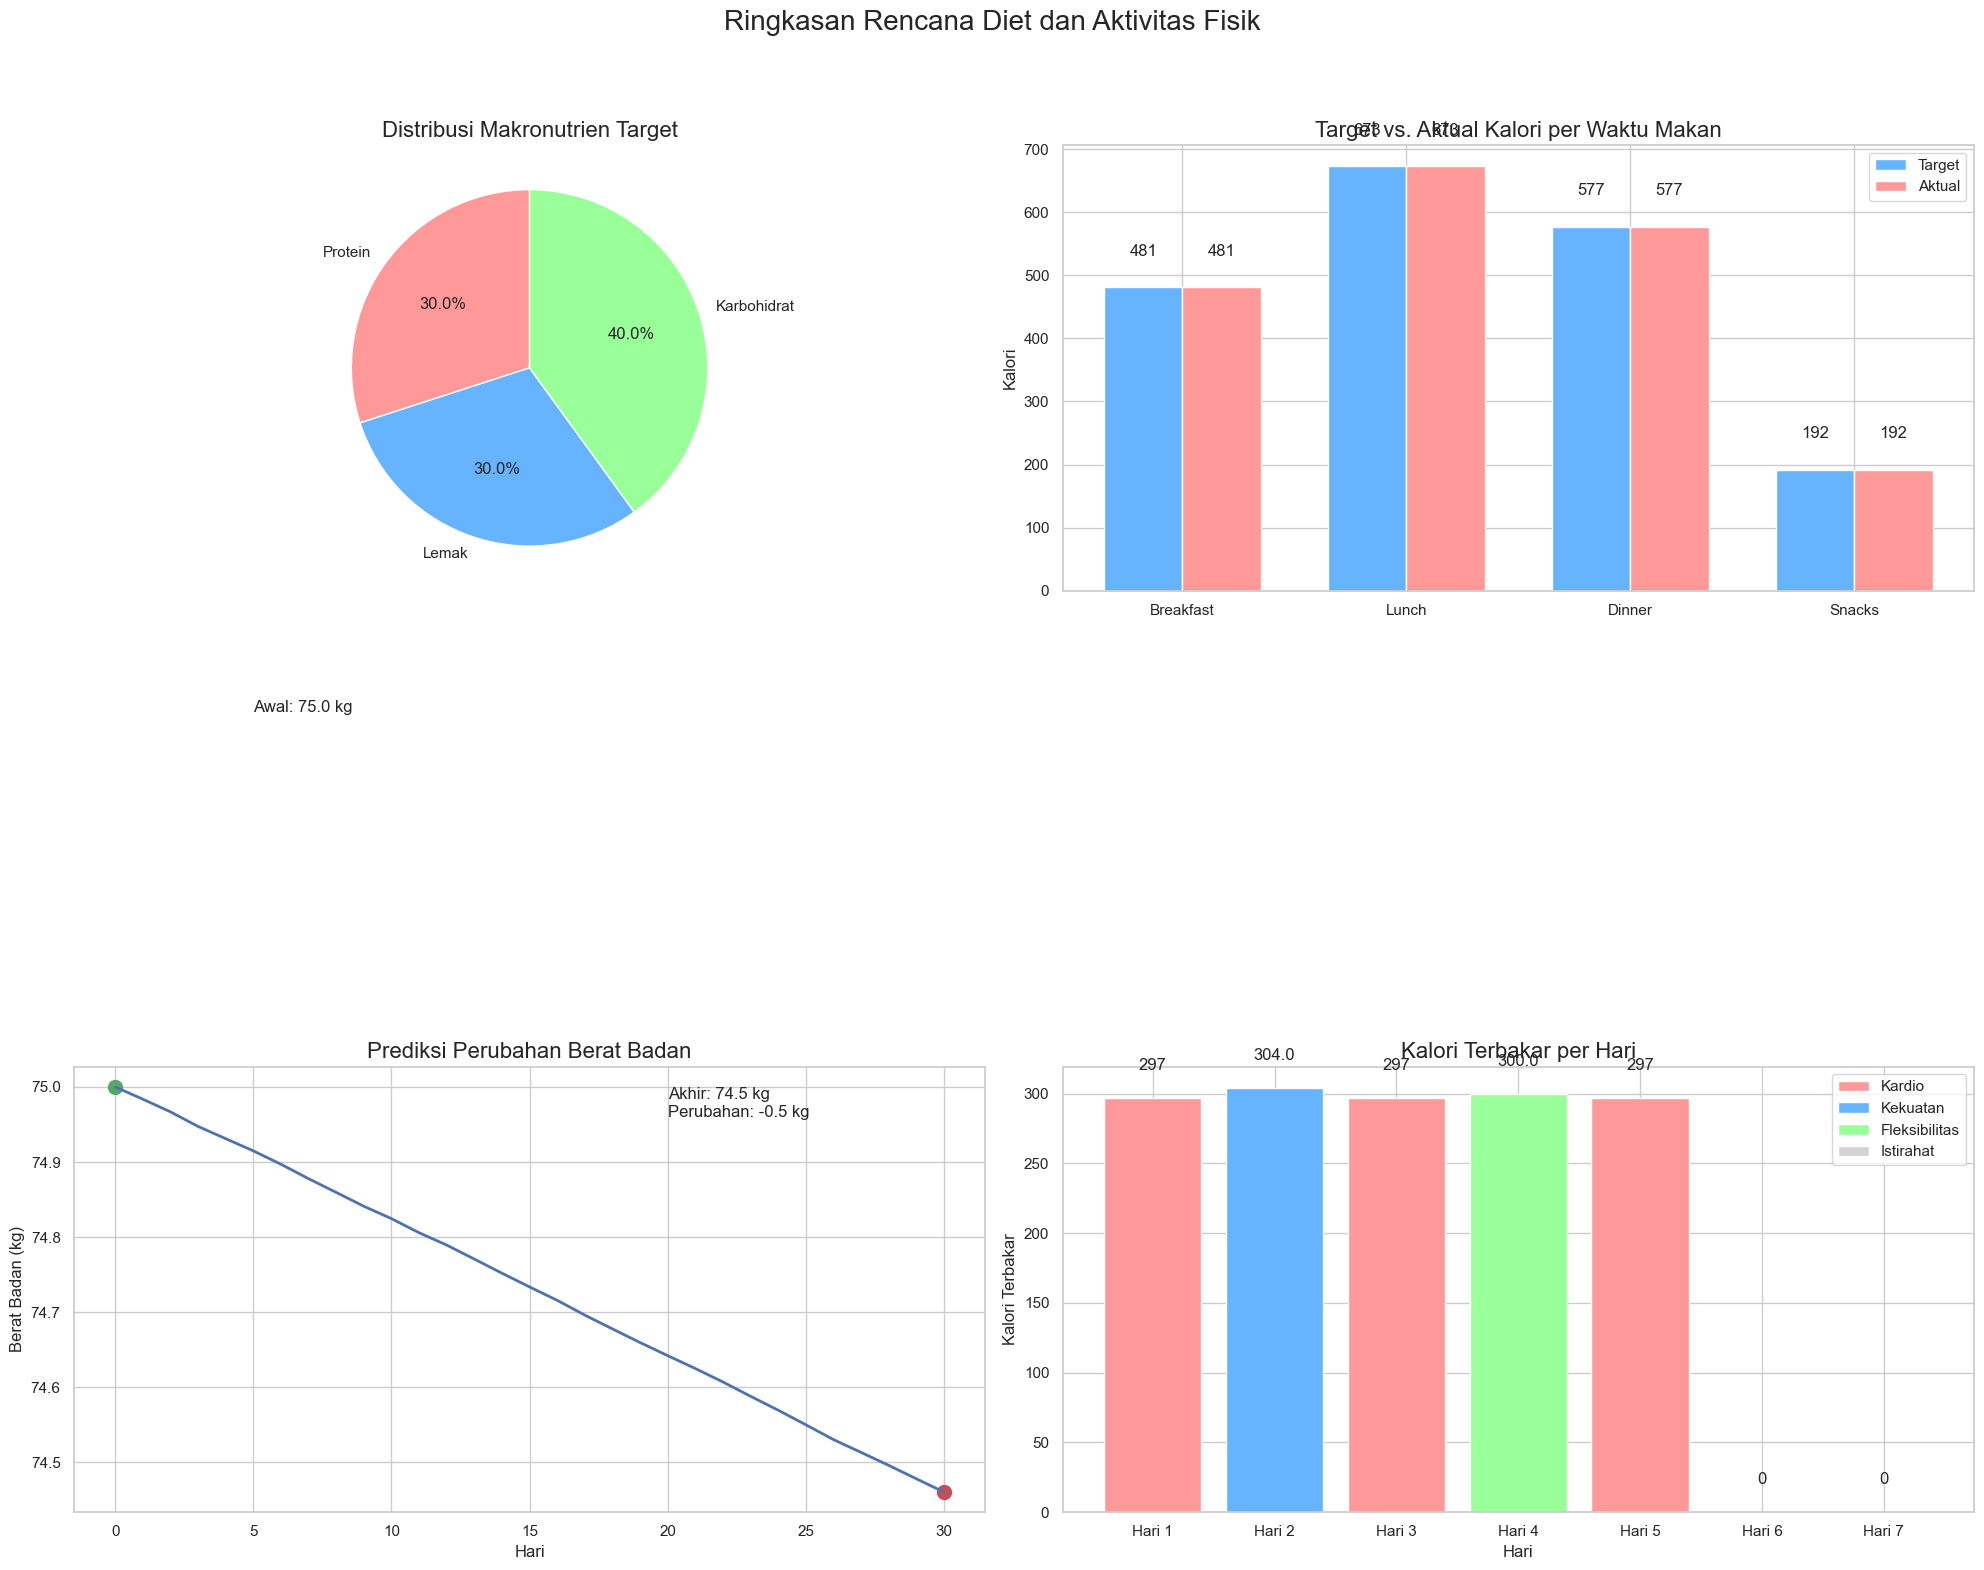

In [15]:
def visualize_results(plan):
    """
    Membuat visualisasi dari hasil rencana diet.
    
    Parameters:
    plan (dict): Rencana lengkap dari generate_complete_plan
    """
    # Buat figure dengan 2x2 subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Visualisasi distribusi makronutrien
    ax1 = fig.add_subplot(221)
    macros = plan['daily_targets']['macros']
    macro_labels = ['Protein', 'Lemak', 'Karbohidrat']
    macro_values = [macros['protein_pct'], macros['fat_pct'], macros['carbs_pct']]
    macro_colors = ['#ff9999', '#66b3ff', '#99ff99']
    
    ax1.pie(macro_values, labels=macro_labels, colors=macro_colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Distribusi Makronutrien Target', fontsize=16)
    
    # 2. Visualisasi perbandingan target vs. aktual kalori
    ax2 = fig.add_subplot(222)
    
    meal_types = [meal for meal in plan['meal_plan'] if meal != 'daily_totals']
    target_calories = [plan['meal_plan'][meal]['targets']['calories'] for meal in meal_types]
    actual_calories = [plan['meal_plan'][meal]['totals']['calories'] for meal in meal_types]
    
    x = np.arange(len(meal_types))
    width = 0.35
    
    ax2.bar(x - width/2, target_calories, width, label='Target', color='#66b3ff')
    ax2.bar(x + width/2, actual_calories, width, label='Aktual', color='#ff9999')
    
    ax2.set_title('Target vs. Aktual Kalori per Waktu Makan', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels([meal.capitalize() for meal in meal_types])
    ax2.legend()
    ax2.set_ylabel('Kalori')
    
    # Tambahkan nilai di atas bar
    for i, v in enumerate(target_calories):
        ax2.text(i - width/2, v + 50, str(v), ha='center')
    
    for i, v in enumerate(actual_calories):
        ax2.text(i + width/2, v + 50, str(v), ha='center')
    
    # 3. Visualisasi trajektori berat badan
    ax3 = fig.add_subplot(223)
    
    trajectory_df = pd.DataFrame(plan['weight_trajectory'])
    ax3.plot(trajectory_df['day'], trajectory_df['weight'], 'b-', linewidth=2)
    
    # Tambahkan titik awal dan akhir
    ax3.scatter([0], [trajectory_df['weight'].iloc[0]], color='g', s=100)
    ax3.scatter([trajectory_df['day'].max()], [trajectory_df['weight'].iloc[-1]], color='r', s=100)
    
    ax3.set_title('Prediksi Perubahan Berat Badan', fontsize=16)
    ax3.set_xlabel('Hari')
    ax3.set_ylabel('Berat Badan (kg)')
    ax3.grid(True)
    
    # Tambahkan anotasi untuk berat awal dan akhir
    ax3.annotate(f"Awal: {trajectory_df['weight'].iloc[0]:.1f} kg", 
                xy=(0, trajectory_df['weight'].iloc[0]),
                xytext=(5, trajectory_df['weight'].iloc[0] + 0.5))
    
    ax3.annotate(f"Akhir: {trajectory_df['weight'].iloc[-1]:.1f} kg\nPerubahan: {trajectory_df['weight'].iloc[-1] - trajectory_df['weight'].iloc[0]:.1f} kg", 
                xy=(trajectory_df['day'].max(), trajectory_df['weight'].iloc[-1]),
                xytext=(trajectory_df['day'].max() - 10, trajectory_df['weight'].iloc[-1] + 0.5))
    
    # 4. Visualisasi aktivitas mingguan
    ax4 = fig.add_subplot(224)
    
    days = list(plan['activity_plan']['daily_plan'].keys())
    calories_burned = [day_plan['total_calories_burned'] for day_plan in plan['activity_plan']['daily_plan'].values()]
    day_types = [day_plan['day_type'].capitalize() for day_plan in plan['activity_plan']['daily_plan'].values()]
    
    # Buat warna berdasarkan jenis hari
    colors = []
    for day_type in day_types:
        if day_type == 'Rest':
            colors.append('#d3d3d3')  # Abu-abu untuk istirahat
        elif day_type == 'Cardio':
            colors.append('#ff9999')  # Merah untuk kardio
        elif day_type == 'Strength':
            colors.append('#66b3ff')  # Biru untuk kekuatan
        else:
            colors.append('#99ff99')  # Hijau untuk fleksibilitas
    
    ax4.bar(days, calories_burned, color=colors)
    ax4.set_title('Kalori Terbakar per Hari', fontsize=16)
    ax4.set_xlabel('Hari')
    ax4.set_ylabel('Kalori Terbakar')
    ax4.set_xticks(days)
    ax4.set_xticklabels([f"Hari {int(day) + 1}" for day in days])
    
    # Tambahkan nilai di atas bar
    for i, v in enumerate(calories_burned):
        ax4.text(i, v + 20, str(v), ha='center')
    
    # Tambahkan legenda untuk jenis hari
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff9999', label='Kardio'),
        Patch(facecolor='#66b3ff', label='Kekuatan'),
        Patch(facecolor='#99ff99', label='Fleksibilitas'),
        Patch(facecolor='#d3d3d3', label='Istirahat')
    ]
    ax4.legend(handles=legend_elements, loc='upper right')
    
    # Tambahkan judul utama
    fig.suptitle('Ringkasan Rencana Diet dan Aktivitas Fisik', fontsize=20)
    
    # Atur layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig

# Contoh penggunaan visualisasi
def main_with_visualization():
    # Memuat dataset
    food_data, activity_data, cardio_data = load_datasets()
    
    # Inisialisasi aplikasi
    app = DietApp(food_data, activity_data, cardio_data)
    
    # Buat profil pengguna contoh
    user_profile = app.create_user_profile(
        user_id='user123',
        weight=75,  # kg
        height=175,  # cm
        age=30,
        gender='male',
        activity_level='lightly_active',
        goal='weight_loss',
        allergies=['kacang', 'seafood'],
        fitness_level='intermediate',
        metabolism_type='normal'
    )
    
    # Hasilkan rencana lengkap
    plan = app.generate_complete_plan(user_profile)
    
    # Visualisasikan hasil
    fig = visualize_results(plan)
    plt.show()

if __name__ == "__main__":
    main_with_visualization()

## Kesimpulan

Kode di atas menyediakan implementasi lengkap untuk sistem rekomendasi makanan dan aktivitas fisik untuk aplikasi diet Anda. Sistem ini mencakup:

1. **Model Perhitungan Kebutuhan Kalori** menggunakan rumus Harris-Benedict dengan penyesuaian berdasarkan tujuan dan tingkat aktivitas.

2. **Algoritma Rekomendasi Makanan** yang menyarankan makanan berdasarkan kebutuhan nutrisi, preferensi, dan alergi pengguna.

3. **Model Prediksi Perubahan Berat Badan** berdasarkan defisit/surplus kalori harian dan faktor metabolisme.

4. **Algoritma Rekomendasi Aktivitas Fisik** dengan fokus pada aktivitas kardio (lari) yang disesuaikan dengan tingkat kebugaran.

5. **Sistem Pembelajaran Adaptif** yang menyesuaikan rekomendasi berdasarkan feedback dan pola keberhasilan pengguna.

6. **Visualisasi** untuk membantu pengguna memahami rencana diet dan aktivitas fisik mereka.